# Libraries

In [32]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from trendfilter import trend_filter

# Data

In [3]:
train_events = pd.read_csv("train_events.csv")

In [4]:
series_has_NaN = train_events.groupby('series_id')['step'].apply(lambda x: x.isnull().any())
no_NaN_series = series_has_NaN[~series_has_NaN].index.tolist()
# also drop these two "truncated" events series seen in EDA:
no_NaN_series.remove('31011ade7c0a') # incomplete events data
no_NaN_series.remove('a596ad0b82aa') # incomplete events data

In [5]:
def get_train_series(series):
    train_series = pd.read_parquet("train_series.parquet", filters=[('series_id','=',series)])
    train_events = pd.read_csv("train_events.csv").query('series_id == @series')
    
    train_events = train_events.dropna()
    train_events["step"]  = train_events["step"].astype("int")
    train_events["awake"] = train_events["event"].replace({"onset":1,"wakeup":0})

    train = pd.merge(train_series, train_events[['step','awake']], on='step', how='left')
    train["awake"] = train["awake"].bfill(axis ='rows')
    # final section:
    # train_events.groupby('series_id').tail(1)["event"].unique()
    # Result: the last event is always a "wakeup"
    train['awake'] = train['awake'].fillna(1) # awake
    train["awake"] = train["awake"].astype("int")
    return(train)

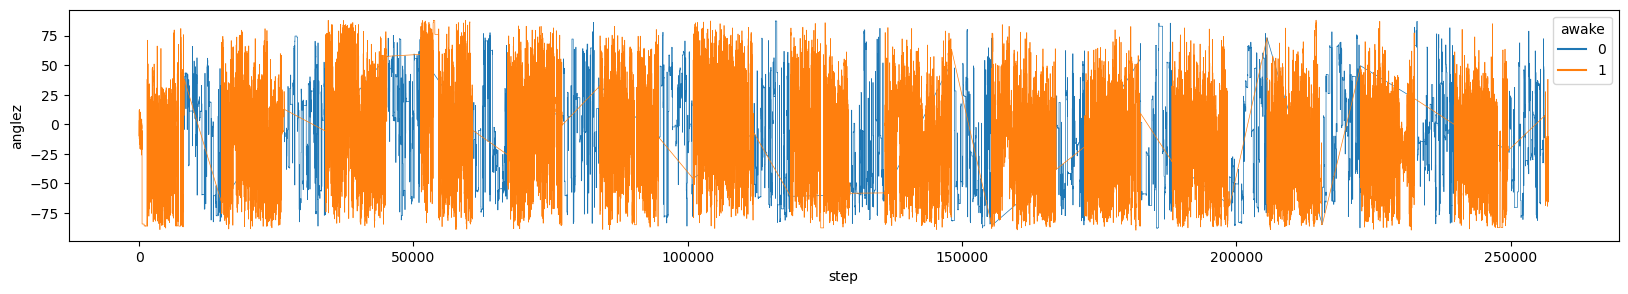

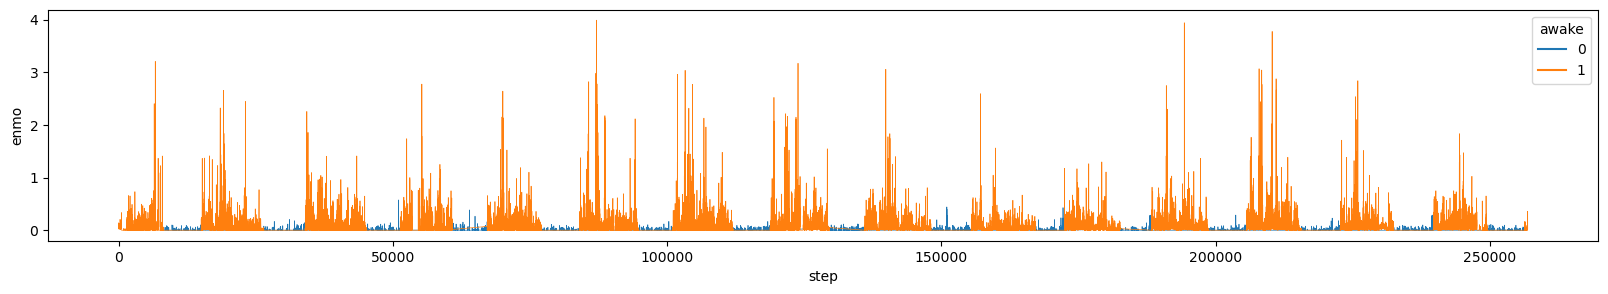

In [6]:
# Focus on data from one subject for now
train = get_train_series(no_NaN_series[1])
    
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=train, x="step", y="anglez",hue="awake", linewidth = 0.5)
plt.show();
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=train, x="step", y="enmo",hue="awake", linewidth = 0.5)
plt.show();

# Switching Markov Model

Local level model with switching variance for anglez data

In [7]:
switch = sm.tsa.MarkovRegression(
    train.iloc[1:, 3],
    k_regimes = 2,
    exog = train.iloc[:-1, 3],
    switching_variance = True)
switch_fit = switch.fit()

/usr/local/linux/mambaforge-3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/linux/mambaforge-3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [8]:
switch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 anglez   No. Observations:               256859
Model:               MarkovRegression   Log Likelihood             2176733.817
Date:                Thu, 28 Sep 2023   AIC                       -4353451.634
Time:                        12:35:20   BIC                       -4353367.984
Sample:                             0   HQIC                      -4353427.278
                             - 256859                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5244   1.13e-22  -3.12e+22      0.000      -3.524      -3.524
x1             0.9049    4.4e-22   2.05e+21      0.000       0.905       0.905
sigma2       462.0961   8.62e-25   5.36e+26      0.000     462.096     462.096
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.29e-13   1.09e-15   -118.311      0.000   -1.31e-13   -1.27e-13
x1             1.0000   2.28e-17   4.39e+16      0.000       1.000       1.000
sigma2      6.228e-26   1.93e-13   3.22e-13      1.000   -3.79e-13    3.79e-13
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9897   4.03e-22   2.46e+21      0.000       0.990       0.990
p[1->0]        0.0579   3.98e-21   1.45e+19      0.000       0.058       0.058
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 1.23e+38. Standard errors may be unstable.
"""

<AxesSubplot: title={'center': 'Probability of being in a high-variance regime'}>

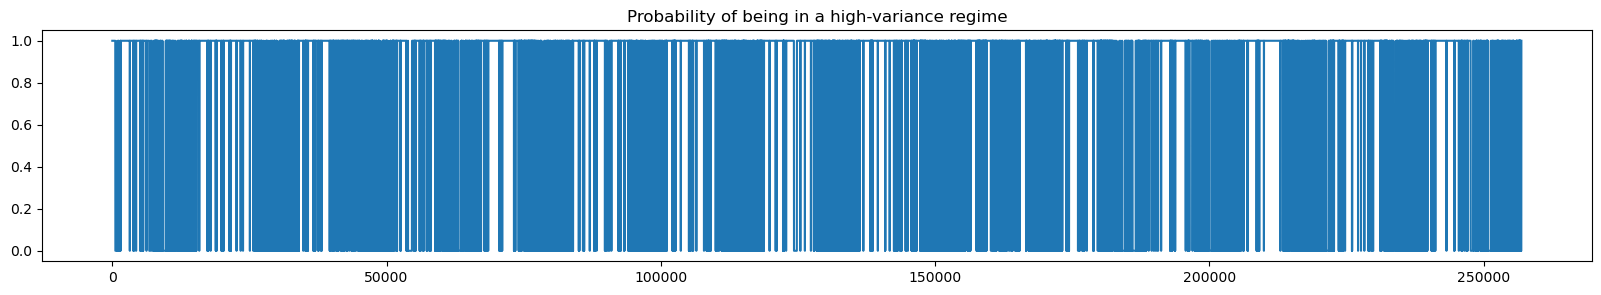

In [9]:
switch_fit.smoothed_marginal_probabilities[0].plot(
    title="Probability of being in a high-variance regime", figsize=(20, 3))

In [10]:
pred = np.array(round(switch_fit.smoothed_marginal_probabilities[0])).astype(int)

In [11]:
confusion_matrix = pd.crosstab(pred, train.iloc[1:, 5], rownames=['Predicted'], colnames=['Observed'])
confusion_matrix

Observed,0,1
Predicted,,
0,89346,14628
1,9546,143339


In [19]:
accuracy = (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 1]) / np.sum(np.sum(confusion_matrix))
accuracy

0.9058861087211272

About 90% of the data points are classified correctly.

Check first 30000 data points vs predictions.

We would expect the predictions to look like a piecewise constant function, but there are some jumps we do not want.

We can use trend filtering as a remedy.

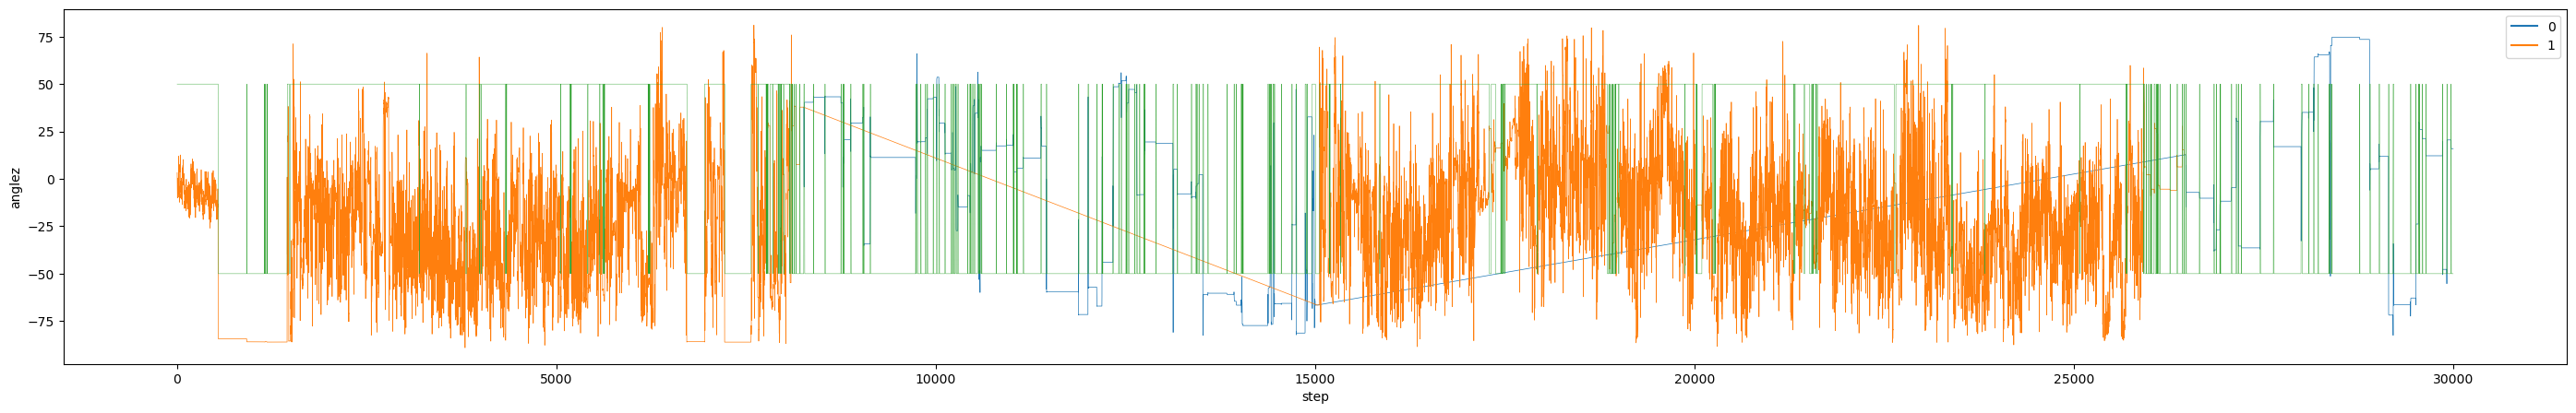

In [28]:
fig, ax = plt.subplots(figsize=(35, 5))
sns.lineplot(data=train.iloc[:30000,:], x="step", y="anglez",hue="awake", linewidth = 0.5)
sns.lineplot(np.append(pred[0], pred[:29999]) * 100 - 50, linewidth = 0.3)
plt.show();

# Trend filter

In [33]:
x = np.linspace(0, len(pred), len(pred))

In [34]:
tf = trend_filter(x, pred, l_norm=1, alpha_1=100)

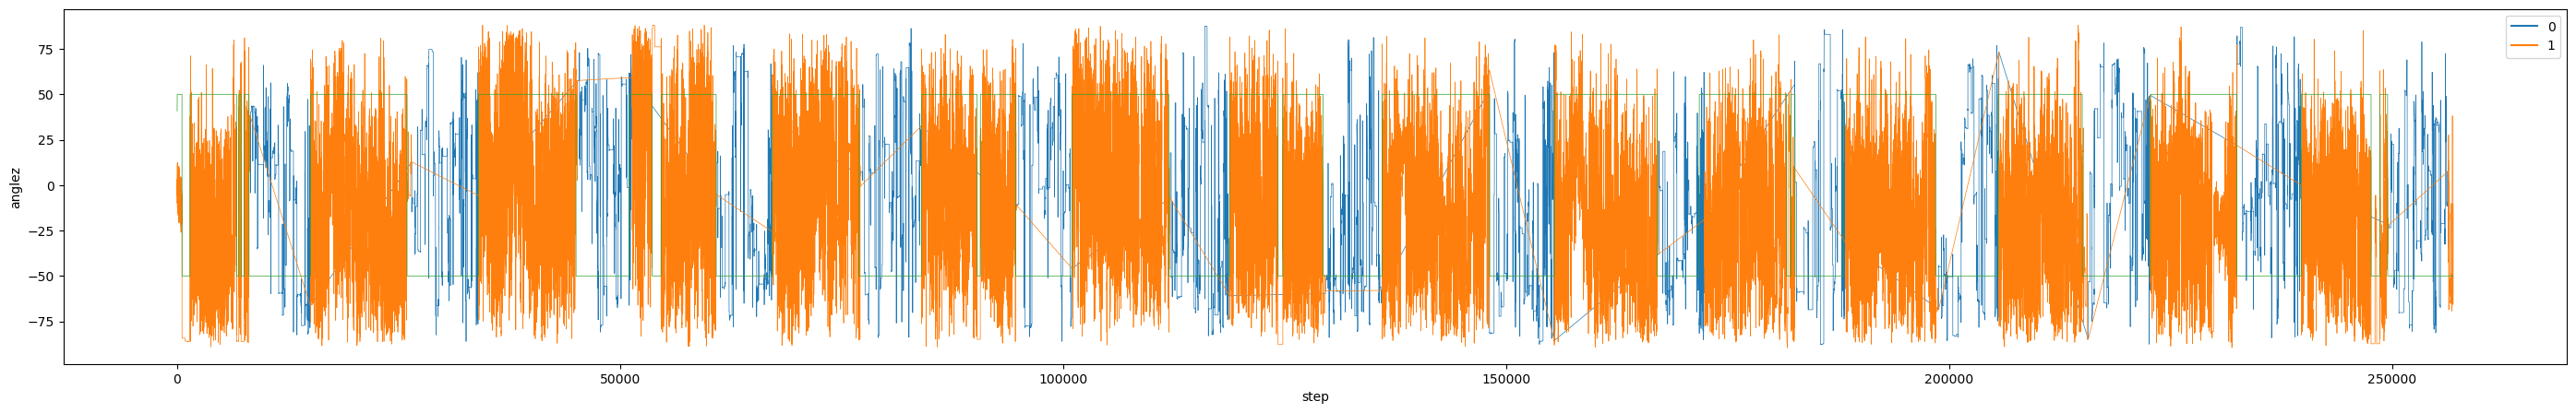

In [37]:
train['tf'] = np.append(tf['y_fit'][0], np.round(tf['y_fit'])) * 50
fig, ax = plt.subplots(figsize=(35, 5))
sns.lineplot(data=train, x="step", y="anglez",hue="awake", linewidth = 0.5)
sns.lineplot(np.append(tf['y_fit'][0], np.round(tf['y_fit'])) * 100 - 50, linewidth = 0.5)
plt.show();

Looks much better.

In [39]:
confusion_matrix = pd.crosstab(np.round(tf['y_fit']), train.iloc[1:, 5], rownames=['Predicted'], colnames=['Observed'])
confusion_matrix

Observed,0,1
Predicted,,
0.0,97590,8476
1.0,1302,149491


In [40]:
accuracy = (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 1]) / np.sum(np.sum(confusion_matrix))
accuracy

0.9619324220681386

Accuracy improved significantly.

Changing trend filter hyperparameter can improve the classification even more.

In [42]:
tf = trend_filter(x, pred, l_norm=1, alpha_1=200)

In [44]:
confusion_matrix = pd.crosstab(np.round(tf['y_fit']), train.iloc[1:, 5], rownames=['Predicted'], colnames=['Observed'])
confusion_matrix

Observed,0,1
Predicted,,
0.0,97590,7059
1.0,1302,150908


# To do/think
- Only using anglez now. How to exploit enmo data too?
- Can we make this faster?
- Maybe tune trend filter parameter using all the time series and cross-validation.
- To improve accuracy we need to incorporate the constraints explained in the challenge description (i.e. one sleeping period per day, ...)

# Old code

In [241]:
ind0 = np.where(pred == 0)[0]

In [243]:
pred_new = pred.copy()
window = 100
for i in range(100, len(pred)-100):
    if np.mean(pred_new[i-window : i+window]) < 0.5:
        pred_new[i] = 0
    else:
        pred_new[i] = 1

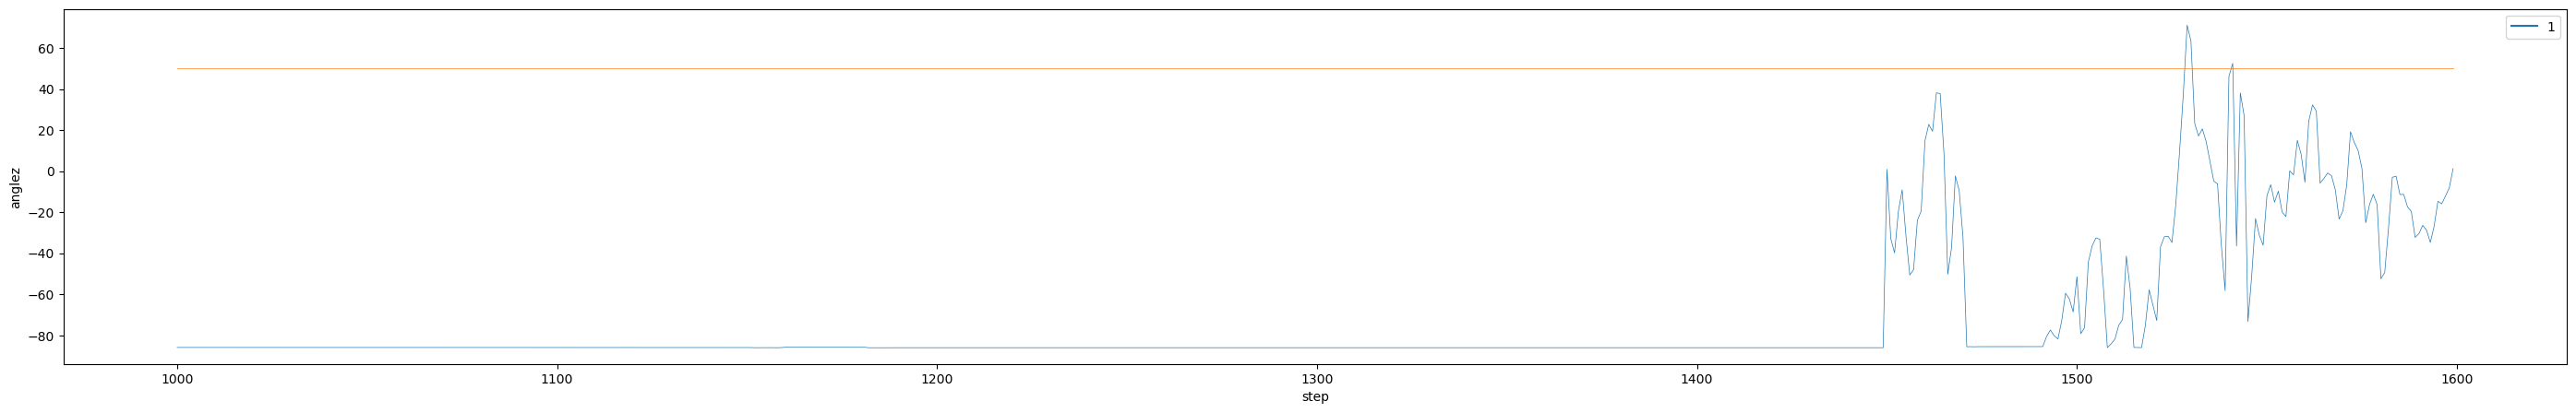

In [244]:
train['pred_new'] = np.append(pred_new[0], pred_new) * 50
fig, ax = plt.subplots(figsize=(35, 5))
sns.lineplot(data=train.iloc[1000:1600, :], x="step", y="anglez",hue="awake", linewidth = 0.5)
sns.lineplot(data=train.iloc[1000:1600, :], x="step", y="pred_new",linewidth = 0.5)
plt.show();